Assignment for 2022/2023 CA683 Data Analytics and Data Mining


<a id="1"></a> <br>
## Import packages

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pickle
import time

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns


from wordcloud import WordCloud, STOPWORDS

stopword=set(STOPWORDS)

import warnings
warnings.filterwarnings("ignore")

<a id="2"></a> <br>
## Load data
**Loading the datasets from google drive. Modify the code if you have the dataset locally**

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train = pd.read_csv("/content/gdrive/MyDrive/jigsaw-toxic-comment-train.csv")

In [ ]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 136.0 MB


In [ ]:
for dtype in ['int64','object']:
    selected_dtype = train.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for int64 columns: 1.46 MB
Average memory usage for object columns: 41.92 MB


In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


<a id="3"></a> <br>
## Data exploration

**Workcloud for all the comments in train**

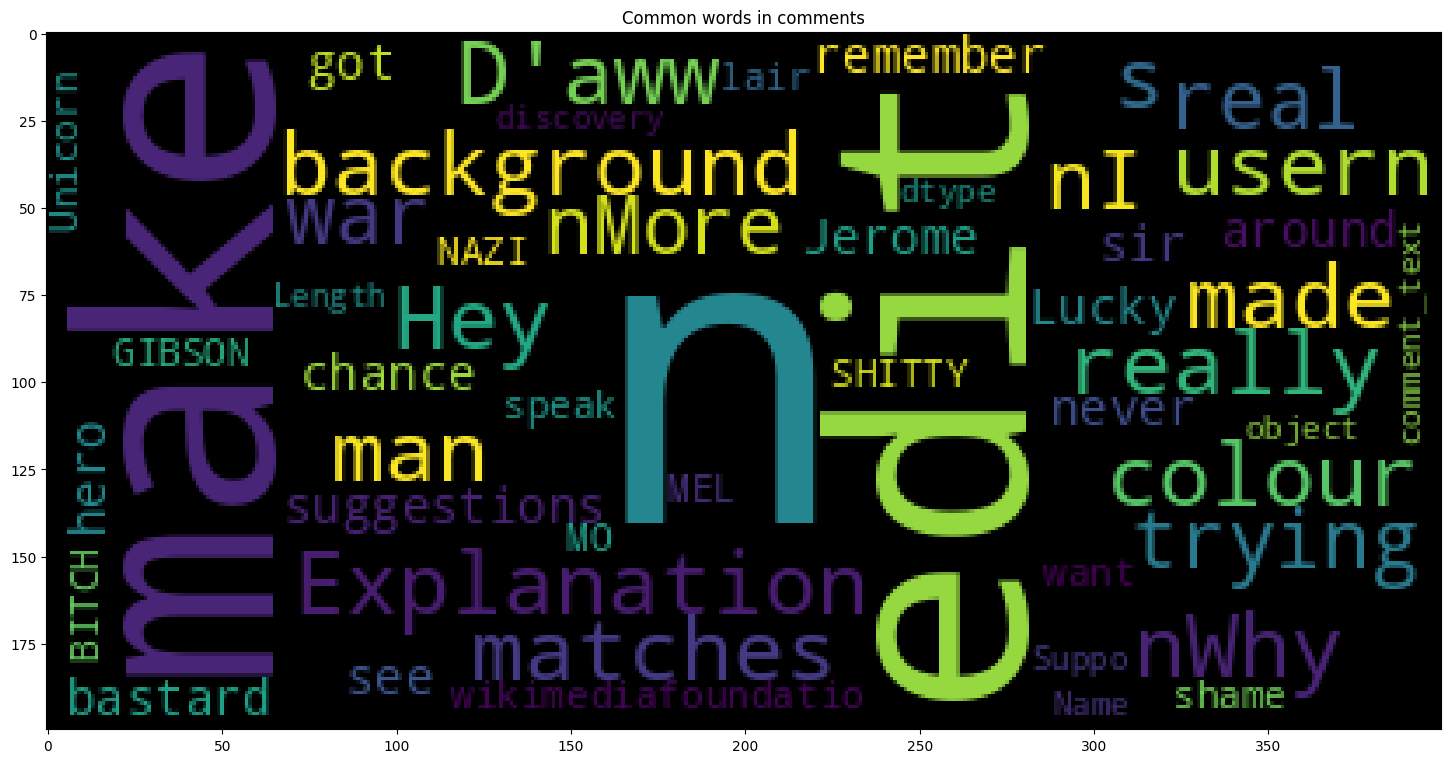

In [ ]:
wc = WordCloud(stopwords=stopword)
plt.figure(figsize=(18,10))
wc.generate(str(train['comment_text']))
plt.imshow(wc)
plt.title('Common words in comments');

In the wordcloud above, we can see the most common words in the comments. These words include "edit", "Explanation", and "background" among other words. More offensive words like "Bastard" and "Nazi" seem to occur less often, indicating that toxic, insulting comments are seen less frequently than non-toxic comments.

**Comment words **

Now, I will look at the number of words present in the comments.

Distribution of comment words

In [ ]:
def new_len(x):
    if type(x) is str:
        return len(x.split())
    else:
        return 0

train["comment_words"] = train["comment_text"].apply(new_len)

From the plot above, we can see that the distribution of comment words has a strong rightward (positive) skew with maximum probability denisty occuring at around 13 words. As the number of words increases beyond 13, the frequency reduces sharply.

Targets 
Now, I will visualize the targets in the dataset.

**Wordclouds for different categories**

Non-toxic vs. Toxic

In [ ]:
Toxic = train[train['toxic'] == 1]
NoToxic = train[train['toxic'] == 0]

**WorkCloud for toxic comments**

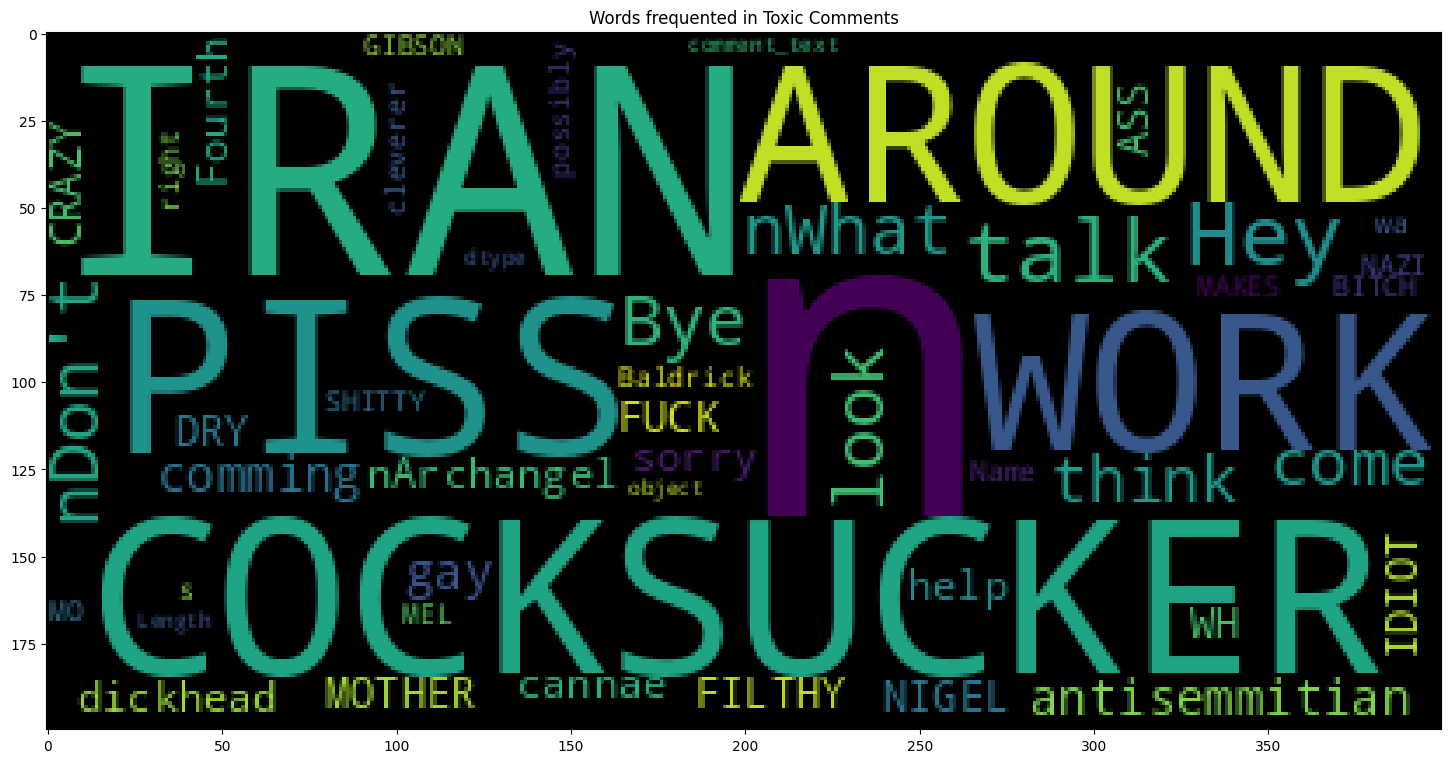

In [ ]:
wc = WordCloud(stopwords= stopword)
plt.figure(figsize = (18,12))
wc.generate(str(Toxic['comment_text']))
plt.imshow(wc)
plt.title('Words frequented in Toxic Comments');

**WorkCloud for clean comments**

Text(0.5, 1.0, 'Words frequented in Clean Comments')

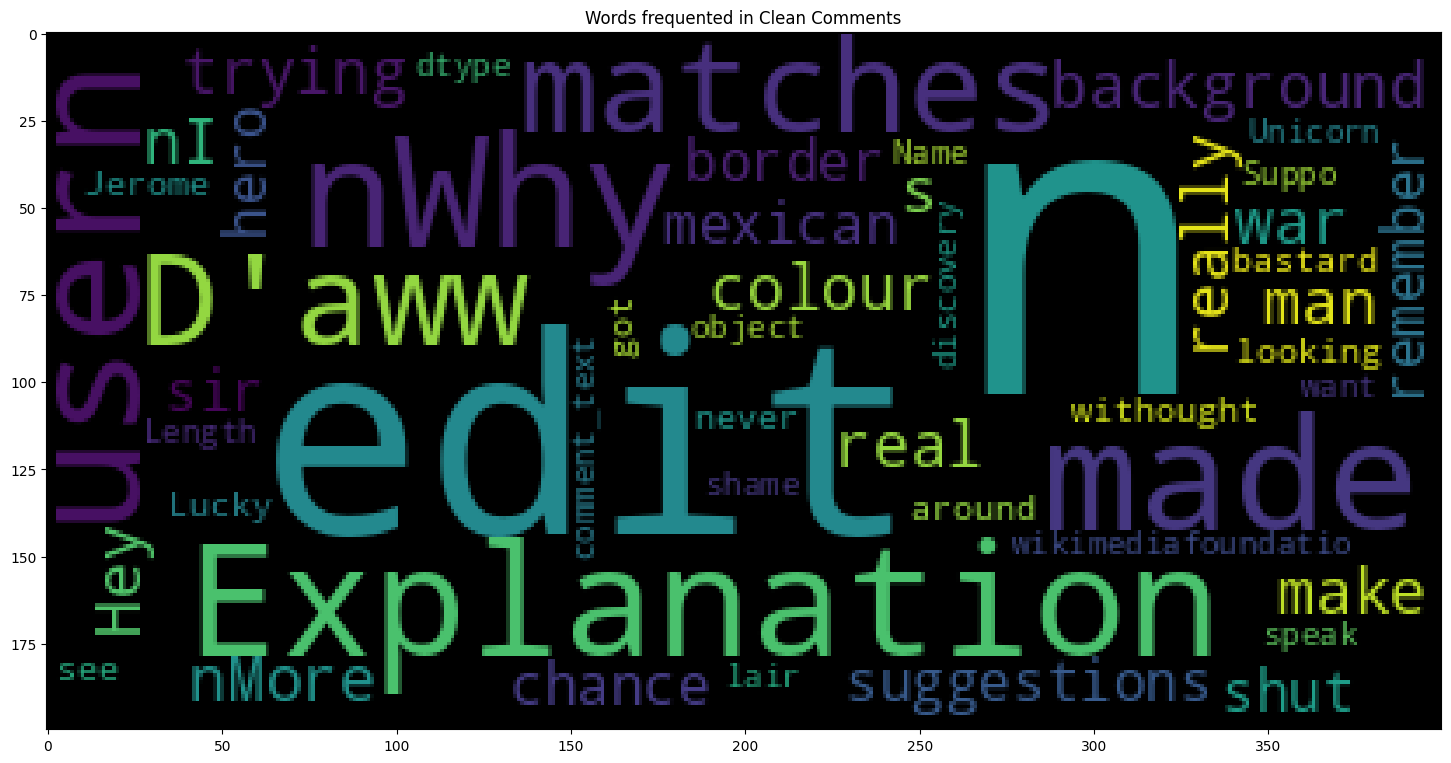

In [ ]:
wc = WordCloud(stopwords= stopword)
plt.figure(figsize = (18,12))
wc.generate(str(NoToxic['comment_text']))
plt.imshow(wc)
plt.title('Words frequented in Clean Comments')

We can see from the above wordclouds, that toxic comments use more insluting or hateful words such as "f**k" or "idiot", while the non-toxic comments do not usually use such words.

<a id="4"></a> <br>
## Modeling



In [ ]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [ ]:
train = train.loc[:30000,:]
train.shape

(30001, 4)

<a id="5"></a> <br>
## Text preprocessing

In [ ]:
#We will check the maximum number of words that can be present in a comment , this will help us in padding later

train['comment_text'].apply(lambda x:len(str(x).split())).max()

1403

In [ ]:
#Writing a function for getting auc score for validation

def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:
from nltk.corpus import stopwords
import nltk
import re
import string, collections
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = EnglishStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() #make text lowercase and fill na
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('\\n', '',str(text))
    text = re.sub("\[\[User.*",'',str(text))
    text = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(text))
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) #remove hyperlinks
    text = re.sub(r'\:(.*?)\:', '', text) #remove emoticones
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', str(text)) #remove email
    text = re.sub(r'(?<=@)\w+', '', text) #remove @
    text = re.sub(r'[0-9]+', '', text) #remove numbers
    text = re.sub("[^A-Za-z0-9 ]", '', text) #remove non alphanumeric like ['@', '#', '.', '(', ')']
    text = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', '', text) #remove punctuations from sentences
    text = re.sub('<.*?>+', '', str(text))
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text))
    text = re.sub('\w*\d\w*', '', str(text))
    text = tokenizer.tokenize(text)
    text = [word for word in text if not word in stop_words]
    #text = [lemmatizer.lemmatize(word) for word in text]
    text = [stemmer.stem(word) for word in text]
    final_text = ' '.join( [w for w in text if len(w)>1] ) #remove word with one letter
    return final_text

train['comment_text'] = train['comment_text'].apply(lambda x : clean_text(x))  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train.head()

,id,comment_text,toxic,comment_words
0,0000997932d777bf,explanationwhi edit made usernam hardcor metal...,0,43
1,000103f0d9cfb60f,daww match background colour im seem stuck tha...,0,17
2,000113f07ec002fd,hey man im realli tri edit war guy constant re...,0,42
3,0001b41b1c6bb37e,morei cant make real suggest improv wonder sec...,0,113
4,0001d958c54c6e35,sir hero chanc rememb page that,0,13


In [ ]:

xtrain, xval, ytrain, yval = train_test_split(train['comment_text'].values, train['toxic'].values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

<a id="13"></a> <br>
## Logistic regression

In [ ]:
train.head()

,id,comment_text,toxic,comment_words
0,0000997932d777bf,explanationwhi edit made usernam hardcor metal...,0,43
1,000103f0d9cfb60f,daww match background colour im seem stuck tha...,0,17
2,000113f07ec002fd,hey man im realli tri edit war guy constant re...,0,42
3,0001b41b1c6bb37e,morei cant make real suggest improv wonder sec...,0,113
4,0001d958c54c6e35,sir hero chanc rememb page that,0,13


**Basic preprocessing**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import  SMOTE


smt = SMOTE(random_state=777, k_neighbors=1)

vec = TfidfVectorizer(min_df=3,max_features=10000,strip_accents='unicode',
                     analyzer='word',ngram_range=(1,2),token_pattern=r'\w{1,}',use_idf=1,smooth_idf=1,sublinear_tf=1,
                     stop_words='english')

vec_fit=vec.fit_transform(xtrain)

clf = LogisticRegressionCV()


# Over Sampling
X_SMOTE, y_SMOTE = smt.fit_resample(vec_fit, ytrain)

In [ ]:
from collections import Counter
#we over sampled it 
print(Counter(y_SMOTE))

Counter({0: 21635, 1: 21635})


In [ ]:
#dealed with imbalanced

**Modeling**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=0.1, solver='sag')
scores = cross_val_score(clf, X_SMOTE,y_SMOTE, cv=5,scoring='f1_weighted')

In [ ]:
scores.mean()

0.9021122959594328

In [ ]:
clf.fit(X_SMOTE,y_SMOTE)

LogisticRegression(C=0.1, solver='sag')

**Model performances**

In [ ]:
#Writing a function for getting auc score for validation

def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc


from sklearn import metrics

def print_report1(data, y):
    y_test =  y
    test_features=vec.transform(data)
    y_pred = clf.predict(test_features)
    report = metrics.classification_report(y_test, y_pred, target_names=['Toxic', 'Clean'])
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))
    print()
    print("Auc: %.2f%%" % (roc_auc(y_pred,y_test)))

print_report1(xval, yval)

              precision    recall  f1-score   support

       Toxic       0.97      0.89      0.93      5410
       Clean       0.44      0.78      0.56       591

    accuracy                           0.88      6001
   macro avg       0.71      0.84      0.75      6001
weighted avg       0.92      0.88      0.89      6001

accuracy: 0.881

Auc: 0.84%


<a id="6"></a> <br>
## SIMPLE RNN

In [ ]:
train = pd.read_csv("/content/gdrive/MyDrive/jigsaw-toxic-comment-train.csv")

In [ ]:
import random

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB


In [ ]:
train['comment_text'] = train['comment_text'].apply(lambda x : clean_text(x)) 

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(train['comment_text'].values, train['toxic'].values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

**Basic Overview : What is a RNN?**

Recurrent Neural Network (RNN) are a type of Neural Network where the output from previous step are fed as input to the current step. In traditional neural networks, all the inputs and outputs are independent of each other, but in cases like when it is required to predict the next word of a sentence, the previous words are required and hence there is a need to remember the previous words. Thus RNN came into existence, which solved this issue with the help of a Hidden Layer.

**tokenizer and padding**

In [ ]:
from keras.utils import pad_sequences

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xval))
xtrain_seq = token.texts_to_sequences(xtrain)
xval_seq = token.texts_to_sequences(xval)

#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xval_pad = pad_sequences(xval_seq, maxlen=max_len)

word_index = token.word_index

**Designing RNN Architecture**

Let's built a simple RNN without any pretrained embeddings and one dense layer :

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         10164900  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 10,205,101
Trainable params: 10,205,101
Non-trainable params: 0
_________________________________________________________________
None


**Model's performances**

In [ ]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(ytrain),
                                        y = ytrain                                                    
                                    )
class_weights = dict(zip(np.unique(ytrain), class_weights))



In [ ]:
history = model.fit(xtrain_pad, ytrain, epochs = 5, batch_size = 64, verbose = 2, validation_data = (xval_pad,yval),class_weight=class_weights)

Epoch 1/5
150/150 - 230s - loss: 0.5500 - accuracy: 0.6890 - val_loss: 0.2855 - val_accuracy: 0.8917 - 230s/epoch - 2s/step
Epoch 2/5
150/150 - 211s - loss: 0.1563 - accuracy: 0.9479 - val_loss: 0.2865 - val_accuracy: 0.8783 - 211s/epoch - 1s/step
Epoch 3/5
150/150 - 206s - loss: 0.0430 - accuracy: 0.9898 - val_loss: 0.1933 - val_accuracy: 0.9296 - 206s/epoch - 1s/step
Epoch 4/5
150/150 - 201s - loss: 0.0147 - accuracy: 0.9971 - val_loss: 0.1995 - val_accuracy: 0.9325 - 201s/epoch - 1s/step
Epoch 5/5
150/150 - 199s - loss: 0.0073 - accuracy: 0.9990 - val_loss: 0.2001 - val_accuracy: 0.9438 - 199s/epoch - 1s/step


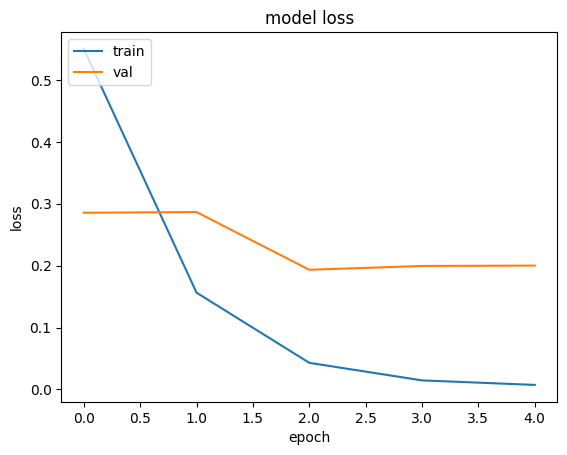

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(xval_pad)

75/75 [==============================] - 9s 113ms/step


In [ ]:
print("Auc: %.2f%%" % (roc_auc(pred,yval)))

Auc: 0.92%


<a id="7"></a> <br>
## LSTM


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-04-10 21:10:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-10 21:10:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-10 21:10:38--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# load the GloVe vectors in a dictionary: ##Embedding

embeddings_index = {}
f = open('glove.6B.200d.txt','r',encoding='utf-8') #200 dimentions, each word will be represented in 200D, to help the model understand what the word means
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:26, 15212.35it/s]

Found 400000 word vectors.


In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 33882/33882 [00:00<00:00, 359494.49it/s]


We have already tokenized and paded our text for input to our previous simple RNN so let's move on into our LSTM model right away.

**Designing LSTM Architecture**

Let's built a simple LSTM glove embeddings and one dense layer :

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     200,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3)) #regularilization 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1500, 200)         6776600   
                                                                 
 lstm (LSTM)                 (None, 100)               120400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 6,897,101
Trainable params: 120,501
Non-trainable params: 6,776,600
_________________________________________________________________
None


**Model's performances**

In [ ]:
history2 = model.fit(xtrain_pad, ytrain, epochs=20, batch_size = 128,validation_data = (xval_pad,yval),class_weight=class_weights)

Epoch 1/20
75/75 [==============================] - 172s 2s/step - loss: 0.4728 - accuracy: 0.7776 - val_loss: 0.3284 - val_accuracy: 0.8808
Epoch 2/20
75/75 [==============================] - 170s 2s/step - loss: 0.3764 - accuracy: 0.8579 - val_loss: 0.4254 - val_accuracy: 0.8304
Epoch 3/20
75/75 [==============================] - 172s 2s/step - loss: 0.3472 - accuracy: 0.8560 - val_loss: 0.2535 - val_accuracy: 0.9129
Epoch 4/20
75/75 [==============================] - 172s 2s/step - loss: 0.3246 - accuracy: 0.8791 - val_loss: 0.3156 - val_accuracy: 0.8800
Epoch 5/20
75/75 [==============================] - 172s 2s/step - loss: 0.3023 - accuracy: 0.8794 - val_loss: 0.2860 - val_accuracy: 0.8908
Epoch 6/20
75/75 [==============================] - 170s 2s/step - loss: 0.2840 - accuracy: 0.8839 - val_loss: 0.2539 - val_accuracy: 0.9029
Epoch 7/20
75/75 [==============================] - 171s 2s/step - loss: 0.2991 - accuracy: 0.8690 - val_loss: 0.2835 - val_accuracy: 0.8858
Epoch 8/20
75

In [ ]:
pred = model.predict(xval_pad)

75/75 [==============================] - 34s 455ms/step


In [ ]:
print("Auc: %.2f%%" % (roc_auc(pred,yval)))

Auc: 0.93%


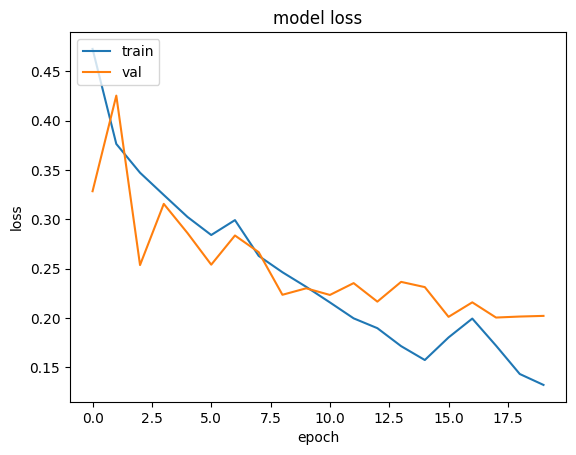

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Let's move to GRU models.

<a id="9"></a> <br>
## GRU's



**Designing GRU architecture**

All of our preprocessing is already done so let's built a GRU with glove embeddings and two dense layers right away.

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     200,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3)) #check
model.add(GRU(300))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1500, 200)         6776600   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1500, 200)        0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 300)               451800    
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 7,228,701
Trainable params: 452,101
Non-trainable params: 6,776,600
_________________________________________________________________
None


**Model's performances**

In [ ]:
history3 = model.fit(xtrain_pad, ytrain, epochs=20, batch_size = 128,validation_data = (xval_pad,yval),class_weight=class_weights)

Epoch 1/20
75/75 [==============================] - 24s 286ms/step - loss: 0.4598 - accuracy: 0.7925 - val_loss: 0.2578 - val_accuracy: 0.9229
Epoch 2/20
75/75 [==============================] - 20s 264ms/step - loss: 0.3734 - accuracy: 0.8388 - val_loss: 0.3106 - val_accuracy: 0.8729
Epoch 3/20
75/75 [==============================] - 21s 278ms/step - loss: 0.3416 - accuracy: 0.8523 - val_loss: 0.4955 - val_accuracy: 0.7792
Epoch 4/20
75/75 [==============================] - 21s 275ms/step - loss: 0.3216 - accuracy: 0.8634 - val_loss: 0.3522 - val_accuracy: 0.8537
Epoch 5/20
75/75 [==============================] - 20s 263ms/step - loss: 0.3072 - accuracy: 0.8685 - val_loss: 0.3530 - val_accuracy: 0.8512
Epoch 6/20
75/75 [==============================] - 21s 278ms/step - loss: 0.2760 - accuracy: 0.8826 - val_loss: 0.3701 - val_accuracy: 0.8438
Epoch 7/20
75/75 [==============================] - 20s 263ms/step - loss: 0.2664 - accuracy: 0.8952 - val_loss: 0.2602 - val_accuracy: 0.9008

In [ ]:
pred = model.predict(xval_pad)
print("Auc: %.2f%%" % (roc_auc(pred,yval)))

75/75 [==============================] - 3s 33ms/step
Auc: 0.95%


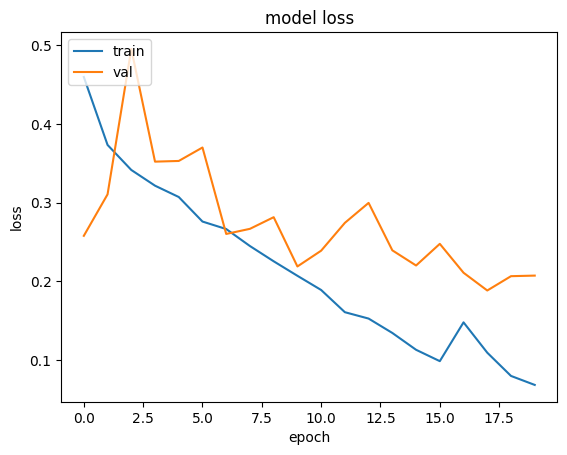

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<a id="10"></a> <br>
## Bi-Directional RNN's

Let's build a simple bidirectional LSTM with glove embeddings and one dense layer

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     200,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 200)         6776600   
                                                                 
 bidirectional (Bidirectiona  (None, 600)              1202400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 601       
                                                                 
Total params: 7,979,601
Trainable params: 1,203,001
Non-trainable params: 6,776,600
_________________________________________________________________
None


In [ ]:
history4 = model.fit(xtrain_pad, ytrain, epochs=20, batch_size = 64,validation_data = (xval_pad,yval),class_weight=class_weights)

Epoch 1/20
150/150 [==============================] - 834s 5s/step - loss: 0.4674 - accuracy: 0.8019 - val_loss: 0.4096 - val_accuracy: 0.8746
Epoch 2/20
150/150 [==============================] - 847s 6s/step - loss: 0.3774 - accuracy: 0.8543 - val_loss: 0.3442 - val_accuracy: 0.8637
Epoch 3/20
150/150 [==============================] - 847s 6s/step - loss: 0.3582 - accuracy: 0.8520 - val_loss: 0.4796 - val_accuracy: 0.7429
Epoch 4/20
150/150 [==============================] - 832s 6s/step - loss: 0.3661 - accuracy: 0.8136 - val_loss: 0.2650 - val_accuracy: 0.8963
Epoch 5/20
150/150 [==============================] - 828s 6s/step - loss: 0.3119 - accuracy: 0.8679 - val_loss: 0.2988 - val_accuracy: 0.8675
Epoch 6/20
150/150 [==============================] - 825s 5s/step - loss: 0.2889 - accuracy: 0.8794 - val_loss: 0.2532 - val_accuracy: 0.9067
Epoch 7/20
150/150 [==============================] - 830s 6s/step - loss: 0.2607 - accuracy: 0.8911 - val_loss: 0.2593 - val_accuracy: 0.9000

In [ ]:
scores = model.predict(xval_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yval)))

75/75 [==============================] - 69s 906ms/step
Auc: 0.94%


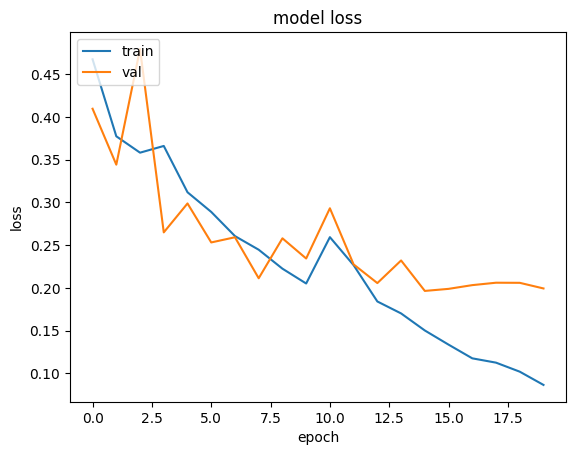

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()